In [1]:
import numpy as np
import gym
import random
import copy
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
class Actor(nn.Module):
    def __init__(self, scaling, state_size, hidden_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * scaling

In [3]:
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class TD3_Agent():
    def __init__(self, scaling, render, buffer_size, batch_size, gamma, tau, noise,
                state_size, hidden_size, action_size, actor_lr, critic_lr):
        
        self.scaling = scaling
        self.render = render
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.noise = noise

        self.state_size = state_size
        self.hidden_size = hidden_size
        self.action_size = action_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        
        self.actor = Actor(scaling, state_size, hidden_size, action_size)
        self.critic = Critic(state_size, hidden_size, action_size)
        self.critic2 = Critic(state_size, hidden_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.target_critic2 = copy.deepcopy(self.critic2)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.critic_optimizer2 = torch.optim.Adam(self.critic2.parameters(), lr = critic_lr)
        
        self.state_memory = []
        self.next_state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.terminal_memory = []
        self.memory_counter = 0
        
    def train(self):
        state = env.reset()
        ep_reward = 0
        num_step = 0
        terminal = False
        
        while not terminal:
            
            if self.render:
                env.render()
                
            tensor_state = torch.from_numpy(state).float()            
            action = self.actor(tensor_state)
            action = torch.add(action, torch.from_numpy(np.random.normal(0, 0.05, self.action_size))) # noise = 0.05
            action = action.detach().numpy()
            next_state, reward, terminal, _ = env.step(action)
            ep_reward += reward

            if self.memory_counter < self.buffer_size: 
                self.state_memory.append(state)
                self.next_state_memory.append(next_state)
                self.action_memory.append(action)
                self.reward_memory.append(reward)
                self.terminal_memory.append(1 - terminal)
            else:     
                index = self.memory_counter % self.buffer_size
                self.state_memory[index] = state
                self.next_state_memory[index] = next_state
                self.action_memory[index] = action
                self.reward_memory[index] = reward
                self.terminal_memory[index] = 1 - terminal
            self.memory_counter += 1    
            
            # If more items in memory list than batch size, sample items from each memory list
            if self.memory_counter >= self.batch_size: 
                batch = random.sample(range(len(self.state_memory)), self.batch_size) 
                states = []
                next_states = []
                actions = []
                rewards = []
                terminals = []
                
                for item in batch:
                    states.append(self.state_memory[item])
                    next_states.append(self.next_state_memory[item])
                    actions.append(self.action_memory[item])
                    rewards.append(self.reward_memory[item])
                    terminals.append(self.terminal_memory[item])
                
                # Reformat sample lists 
                states = np.array(states)
                next_states = np.array(next_states)
                actions = np.array(actions)
                states = torch.tensor(states)
                next_states = torch.tensor(next_states)
                actions = torch.tensor(actions)
                states = states.to(torch.float32) 
                actions = actions.to(torch.float32) 
                next_states = next_states.to(torch.float32) 
                    
                # Gradient descent on critics prep
                target_actions = self.target_actor(next_states)
                actions_copy = copy.deepcopy(actions)
                noise = actions_copy.data.normal_(0, self.noise * 2) # Policy noise    
                noise = noise.clamp(-self.noise * 5, self.noise * 5) # Limit noise effect        
                target_actions = target_actions + noise

                a = self.target_critic(next_states, target_actions)
                b = self.target_critic2(next_states, target_actions)
                next_Qtargets = torch.min(a,b) # Get smallest q-value from each target critic
                Qtargets = []
                for i in range(self.batch_size):
                    Qtargets.append(rewards[i] + self.gamma * next_Qtargets[i] * terminals[i])
                Qtargets = torch.tensor(Qtargets)
                Qtargets = Qtargets.view(self.batch_size, 1)
                
                # Gradient descent on critic 1                
                Qexpected = self.critic(states, actions)
                critic_loss = nn.HuberLoss()(Qexpected, Qtargets)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                # Gradient descent on critic 2
                Qexpected2 = self.critic2(states, actions)
                critic_loss2 = nn.HuberLoss()(Qexpected2, Qtargets)
                self.critic_optimizer2.zero_grad()
                critic_loss2.backward()
                self.critic_optimizer2.step()
                
                # Gradient ascent on actor every 2 steps
                if num_step % 2 == 0:
                    actions_predicted = self.actor(states)
                    actor_loss = -self.critic(states, actions_predicted)
                    actor_loss = torch.mean(actor_loss)
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()
                
                # Update target networks
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic.parameters(), self.critic.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))                    

                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic2.parameters(), self.critic2.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau)) 
                
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_actor.parameters(), self.actor.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))      
                
            state = next_state
            num_step += 1
            
        if self.render:
            env.close()
            
        return ep_reward
        
    def test(self):
        
        scores = []
        
        for i in range(100):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = torch.add(action, torch.from_numpy(np.random.normal(0, self.noise, self.action_size)))
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state
                
            print('Episode reward:', ep_reward)
            scores.append(ep_reward)
            
        print('Scores during testing')
        x = [i for i in range(1, len(scores)+1)]
        plt.plot(x, scores)
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()
        
    def visualise(self):
        for i in range(5):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                env.render()
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = torch.add(action, torch.from_numpy(np.random.normal(0, self.noise, self.action_size)))
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state

            print('Episode reward:', ep_reward)
            env.close()

Episode: 100/2000 Score: -97.781 	 Average over last 100 episodes: -92.522
Episode: 200/2000 Score: -101.235 	 Average over last 100 episodes: -108.975
Episode: 300/2000 Score: -108.603 	 Average over last 100 episodes: -104.867
Episode: 400/2000 Score: -105.569 	 Average over last 100 episodes: -113.215
Episode: 500/2000 Score: -99.025 	 Average over last 100 episodes: -102.156
Episode: 600/2000 Score: -35.308 	 Average over last 100 episodes: -69.872
Episode: 700/2000 Score: 261.821 	 Average over last 100 episodes: 160.578
Episode: 800/2000 Score: 23.151 	 Average over last 100 episodes: 197.764
Episode: 900/2000 Score: 302.193 	 Average over last 100 episodes: 191.752
Episode: 1000/2000 Score: 298.147 	 Average over last 100 episodes: 236.770
Episode: 1100/2000 Score: -110.167 	 Average over last 100 episodes: 85.235
Episode: 1200/2000 Score: -111.402 	 Average over last 100 episodes: -111.632
Episode: 1300/2000 Score: -116.981 	 Average over last 100 episodes: -110.130
Episode: 14

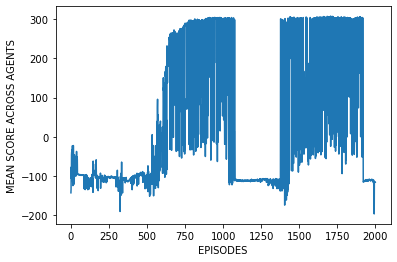

In [5]:
environment = 'BipedalWalker-v3' # Change environment name here
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
elif environment == 'LunarLanderContinuous-v2' or 'BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1

agents = 2
episodes = 2000
all_scores = []
all_moving_means = [] # Mean score of the last X episodes
previous = 100 # Set value of X 

for i in range(1, agents + 1):
    
    agent = TD3_Agent(scaling = scaling, render = False, buffer_size = 1000000, batch_size = 100, gamma = 0.99, tau = 0.001, noise = 0.05,
                state_size = env.observation_space.shape[0], hidden_size = 300, action_size = env.action_space.shape[0], actor_lr = 0.0001, critic_lr = 0.001)
    agent_scores = []
    agent_moving_means = []
    
    for j in range(1, episodes + 1):
        
        ep_reward = agent.train()
        agent_scores.append(ep_reward)
        agent_moving_means.append(np.mean(agent_scores[-previous:])) 
        
        if j % 100 == 0: # How often to print
            print('Episode: {}/{} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(j, episodes, ep_reward, previous, agent_moving_means[j-1])) 
            
    print('*************************************************************')
    print('Agent {} complete \t Mean score of agent: {:.2f}'.format(i, np.mean(agent_scores))) 
    print('*************************************************************')
    all_scores.append(agent_scores)
    all_moving_means.append(agent_moving_means)
    
all_scores = np.array(all_scores)
average_score = all_scores.mean(0) # Average the scores across agents
x = [i for i in range(1, len(average_score) + 1)]
print('Scores during training')
plt.plot(x, average_score)
plt.ylabel('Score averaged across agents')
plt.xlabel('Episodes')              
plt.show()

all_moving_means = np.array(all_moving_means)
average_moving_mean = all_moving_means.mean(0) # Average the means across agents
x = [i for i in range(1, len(average_moving_mean) + 1)]
print('Mean score of last {} episodes during training'.format(previous))
plt.plot(x, average_moving_mean)
plt.ylabel('Mean score of last {} episodes averaged across agents'.format(previous))       
plt.xlabel('Episodes')
plt.show()

Episode reward: -119.1572790397735
Episode reward: -125.53278623416455
Episode reward: -115.35701381681073
Episode reward: -118.8413639617983
Episode reward: -115.85501774182646
Episode reward: -126.26975533884087
Episode reward: -178.42166812457722
Episode reward: -116.02765152856443
Episode reward: -178.91632831399528
Episode reward: -179.5594870805292
Episode reward: -115.61466281930886
Episode reward: -115.32804991378079
Episode reward: -179.50238011068362
Episode reward: -178.3577225394182
Episode reward: -178.63740678733518
Episode reward: -115.44772447066536
Episode reward: -116.41693189901277
Episode reward: -115.4808205289951
Episode reward: -115.75515326620352
Episode reward: -115.89066366150914
Episode reward: -122.97134632806238
Episode reward: -115.20772410426827
Episode reward: -178.49000917237657
Episode reward: -116.60802677226084
Episode reward: -116.53403343996162
Episode reward: -178.78039142377725
Episode reward: -115.38457327473657
Episode reward: -179.820537520225

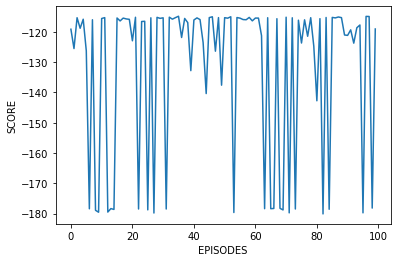

In [6]:
agent.test()

In [8]:
agent.visualise()

2022-05-02 23:04:58.046 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb445c8ee90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:04:58.049 python[8196:257098] Warning: Expected min height of view: (<NSButton: 0x7fb42dd193e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:04:58.052 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb42dd19890>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:04:58.065 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb42dd1bb50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -141.97120683124734


2022-05-02 23:05:14.293 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb446bb45c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:14.293 python[8196:257098] Warning: Expected min height of view: (<NSButton: 0x7fb446bbd2a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:14.296 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb446bbd7a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:14.298 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb446bc44b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -115.66589803191594


2022-05-02 23:05:15.583 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb44cd22f00>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:15.584 python[8196:257098] Warning: Expected min height of view: (<NSButton: 0x7fb44cd2ed30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:15.586 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb44cd2f4c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:15.587 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb44cd30840>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -118.86668304144953


2022-05-02 23:05:17.468 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb44cd39d30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:17.468 python[8196:257098] Warning: Expected min height of view: (<NSButton: 0x7fb44cd25ba0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:17.470 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb44cd26330>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:17.472 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb44cd270b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -178.00621568317828


2022-05-02 23:05:32.745 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb445c6beb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:32.746 python[8196:257098] Warning: Expected min height of view: (<NSButton: 0x7fb44a50a300>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:32.748 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb44cc294c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:32.751 python[8196:257098] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb44a51de50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -115.45817181593944
